<a href="https://colab.research.google.com/github/AmiOgita/memo/blob/main/semseg_trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(42)

cuda


In [3]:
im_width = 512
im_height = 512
im_chan = 1

In [4]:
path_train = '/content/drive/MyDrive/train'
path_test = '/content/drive/MyDrive/test'
path_valid = '/content/drive/MyDrive/validation'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

valid_path_images = os.path.abspath(path_valid + "/images/")
valid_path_masks = os.path.abspath(path_valid + "/masks/")

In [5]:
train_path_images_list = glob(os.path.join(train_path_images, "*.tif"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.tif"))
test_path_images_list = glob(os.path.join(test_path_images, "*.tif"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.tif"))
valid_path_images_list = glob(os.path.join(valid_path_images, "*.tif"))
valid_path_masks_list = glob(os.path.join(valid_path_masks, "*.tif"))

In [6]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]
valid_ids = next(os.walk(valid_path_images))[2]

In [7]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)

print('Getting training data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = cv2.imread(path_train + '/images/' + id_)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[:, :, np.newaxis]
    X_train[n] = img
    
    mask = cv2.imread(path_train + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask[:, :, np.newaxis]
    Y_train[n] = mask
    
print('Done!')

Getting training data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


In [10]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), im_height, im_width, 1), dtype=np.bool_)

print('Getting testing data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = cv2.imread(path_test + '/images/' + id_)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.resize(img,(512,512))
    img = img[:, :, np.newaxis]
    
    X_test[n] = img
    
    mask = cv2.imread(path_test + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.resize(mask,(512,512))
    mask = mask[:, :, np.newaxis]
    Y_test[n] = mask
    
print('Done!')

Getting testing data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


In [12]:
X_valid = np.zeros((len(valid_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_valid = np.zeros((len(valid_ids), im_height, im_width, 1), dtype=np.bool_)

print('Getting validation data...')

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(valid_ids), total=len(valid_ids)):
    img = cv2.imread(path_valid + '/images/' + id_)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[:, :, np.newaxis]
    X_valid[n] = img
    
    mask = cv2.imread(path_valid + '/masks/' + id_)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.resize(mask,(512,512))
    mask = mask[:, :, np.newaxis]
    Y_valid[n] = mask

    
print('Done!')

Getting validation data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Done!


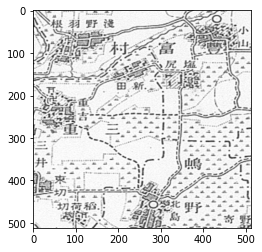

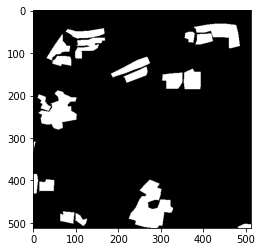

In [13]:
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [14]:
class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask 

In [15]:
train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

test_dataset = Nuc_Seg(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

valid_dataset = Nuc_Seg(X_valid, Y_valid)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = True)

In [16]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
      union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    
      if union == 0:
        iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
      else:
        iou.append(float(intersection) / float(max(union, 1)))
     
    return sum(iou)

In [17]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [23]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1_1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.drop1_1 = nn.Dropout2d(0.1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size = 3, padding = 1)
        
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.drop2_1 = nn.Dropout2d(0.1)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 1)
        
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.drop3_1 = nn.Dropout2d(0.2)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.drop4_1 = nn.Dropout2d(0.2)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv5_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.drop5_1 = nn.Dropout2d(0.3)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        
        self.conv_trans6_1 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = (2, 2))
        self.conv6_1 = nn.Conv2d(256, 128, kernel_size = 3, padding = 1)
        self.drop6_1 = nn.Dropout2d(0.2)
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv_trans7_1 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = (2, 2))
        self.conv7_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.drop7_1 = nn.Dropout2d(0.2)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv_trans8_1 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = (2, 2))
        self.conv8_1 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
        self.drop8_1 = nn.Dropout2d(0.1)
        self.conv8_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 1)
        
        self.conv_trans9_1 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = (2, 2))
        self.conv9_1 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
        self.drop9_1 = nn.Dropout2d(0.1)
        self.conv9_2 = nn.Conv2d(16, 16, kernel_size = 3, padding = 1)
        
        self.conv10 = nn.Conv2d(16, 1, kernel_size = 3, padding = 1)
    
    def forward(self, s):
        
        c1 = F.elu(self.conv1_1(s))
        c1 = self.drop1_1(c1)
        c1 = F.elu(self.conv1_2(c1))
        p1 = F.max_pool2d(c1, kernel_size = (2, 2), stride = 2)
        
        c2 = F.elu(self.conv2_1(p1))
        c2 = self.drop2_1(c2)
        c2 = F.elu(self.conv2_2(c2))
        p2 = F.max_pool2d(c2, kernel_size = (2, 2), stride = 2)
        
        c3 = F.elu(self.conv3_1(p2))
        c3 = self.drop3_1(c3)
        c3 = F.elu(self.conv3_2(c3))
        p3 = F.max_pool2d(c3, kernel_size = (2, 2), stride = 2)
        
        c4 = F.elu(self.conv4_1(p3))
        c4 = self.drop4_1(c4)
        c4 = F.elu(self.conv4_2(c4))
        p4 = F.max_pool2d(c4, kernel_size = (2, 2), stride = 2)
        
        c5 = F.elu(self.conv5_1(p4))
        c5 = self.drop5_1(c5)
        c5 = F.elu(self.conv5_2(c5))
        
        u6 = self.conv_trans6_1(c5)
        u6 = torch.cat((u6, c4), axis = 1)
        c6 = F.elu(self.conv6_1(u6))
        c6 = self.drop6_1(c6)
        c6 = F.elu(self.conv6_2(c6))
        
        u7 = self.conv_trans7_1(c6)
        u7 = torch.cat((u7, c3), axis = 1)
        c7 = F.elu(self.conv7_1(u7))
        c7 = self.drop7_1(c7)
        c7 = F.elu(self.conv7_2(c7))
    
        u8 = self.conv_trans8_1(c7)
        u8 = torch.cat((u8, c2), axis = 1)
        c8 = F.elu(self.conv8_1(u8))
        c8 = self.drop8_1(c8)
        c8 = F.elu(self.conv8_2(c8))
        
        u9 = self.conv_trans9_1(c8)
        u9 = torch.cat((u9, c1), axis = 1)
        c9 = F.elu(self.conv9_1(u9))
        c9 = self.drop9_1(c9)
        c9 = F.elu(self.conv9_2(c9))
        
        output = torch.sigmoid(self.conv10(c9))
        
        return output

In [24]:
model = UNet()
model = model.float()
model = model.to(device)

In [25]:
opt = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 3, verbose = 1)

In [21]:
def fit(model, epochs, opt, loss_func, train_loader, valid_loader, alpha):

    for epoch in range(epochs):
        
        #Going into training mode
        model.train()
        
        train_loss = 0 
        iou = 0
        
        for image, mask in train_loader:
            image = image.to(device)   #Passing the input mini-batch to the GPU
            mask = mask.to(device)   #Passing the label mini-batch to the GPU
            opt.zero_grad()      #Setting the grads to zero to avoid accumulation of gradients
            out = model(image.float())
            loss = loss_func(out.float(), mask.float())    
            train_loss += loss
            
            iou += iou_metric(out, mask)
            iou_rev = 16 - iou_metric(out, mask)
            loss += alpha * iou_rev
            
            loss.backward()
            opt.step()
        
        lr_scheduler.step(train_loss/len(train_loader))   #Setting up lr decay  
        
        model.eval()            #Going into eval mode                            
        with torch.no_grad():   #No backprop
            valid_loss = 0
            valid_iou = 0
            
            for image_val, mask_val in valid_loader:
                image_val = image_val.to(device)  
                mask_val = mask_val.to(device)
                out_val = model(image_val.float())
                valid_loss += loss_func(out_val.float(), mask_val.float())
                
                valid_iou += iou_metric(out_val, mask_val)
        
        print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "CV Loss: ", valid_loss/len(valid_loader))
        print("Training IoU: ", iou/len(train_loader), "CV IoU: ", valid_iou/len(valid_loader))



In [26]:
fit(model, 30, opt, loss_func, train_loader, valid_loader, 5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch  1  Training Loss:  tensor(0.4234, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.2931, device='cuda:0')
Training IoU:  0.00020939124255120114 CV IoU:  0.0
Epoch  2  Training Loss:  tensor(0.3115, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.2971, device='cuda:0')
Training IoU:  0.0 CV IoU:  0.0
Epoch  3  Training Loss:  tensor(0.3071, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.2558, device='cuda:0')
Training IoU:  0.0 CV IoU:  0.0
Epoch  4  Training Loss:  tensor(0.2721, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.3485, device='cuda:0')
Training IoU:  0.001272493762759366 CV IoU:  0.0007067647754293665
Epoch  5  Training Loss:  tensor(0.2880, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.3077, device='cuda:0')
Training IoU:  0.008458348551808312 CV IoU:  0.0018421710941054288
Epoch  6  Training Loss:  tensor(0.2833, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.2539, device='cuda:0')
Trainin